<a href="https://colab.research.google.com/github/pyohamen/yonsei/blob/master/2-1_%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4_%EB%B0%8F_%EB%AA%A8%ED%98%95%EB%B9%84%EA%B5%90/Code12_%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4%ED%81%AC%EA%B8%B0%EA%B2%B0%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan 데이터 분류나무

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('loan.csv')

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df['job'] = df['job'].replace({'Office':0, 'ProfExe':1, 'Other':2, 'Mgr':3, 'Self':4, 'Sales':5})
df.groupby('job').mean()

,y,loan,mortgage,workyear,delinquency,period,inquire,transact,DTI
job,,,,,,,,,
0,0.180909,18104.440000,67958.616364,8.399091,0.436364,177.157945,1.017273,21.200909,34.772091
1,0.204577,18883.011096,92253.009709,8.751040,0.417476,194.267684,1.044383,24.070042,33.676685
2,0.232263,17911.422167,62103.232616,9.272503,0.374162,172.503607,1.288740,19.263678,34.464261
3,0.279412,18947.905462,80028.710084,9.172269,0.558824,173.443193,1.477941,22.580882,36.054979
4,0.403226,23403.201613,85134.940860,7.793011,0.534946,172.465457,1.411290,22.432796,36.581478
5,0.414384,16926.616438,76520.465753,8.065068,0.400685,178.711438,1.184932,22.595890,36.410377


### 나무 모형

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
X = df.drop(['y'], axis=1)
y = df['y']
xname = X.columns
yname = ['Normal','Bad']

### 모든 Alpha 와 Impurity의 계산

In [ ]:
# 계산 능력의 차이
c_tree = DecisionTreeClassifier(random_state=0) 
path = c_tree.cost_complexity_pruning_path(X, y)
path = pd.DataFrame(path)
path

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.000092,0.000554
2,0.000094,0.000837
3,0.000095,0.001122
4,0.000099,0.001420
...,...,...
245,0.003947,0.210085
246,0.009265,0.219351
247,0.022731,0.242082
248,0.025101,0.267183


### Alpha 와 Impurity의 관계

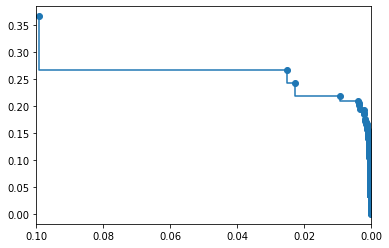

In [ ]:
fig, ax = plt.subplots()
ax.plot(path.ccp_alphas, path.impurities, marker='o', drawstyle="steps-post")
ax.set_xlim(0.1, 0)  # decreasing order
plt.show()

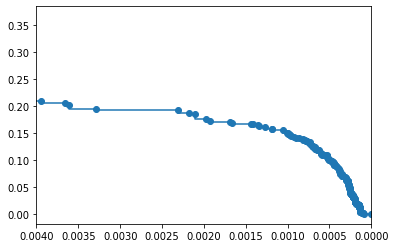

In [ ]:
fig, ax = plt.subplots()
ax.plot(path.ccp_alphas, path.impurities, marker='o', drawstyle="steps-post")
ax.set_xlim(0.004, 0)  # decreasing order
plt.show()

### 최적의 Alpha를 찾는 방법

In [ ]:
from sklearn.model_selection import GridSearchCV
np.random.seed(0)
g_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),
              param_grid={'ccp_alpha': np.arange(0.000, 0.005, 0.0001)}, cv=10, n_jobs=-1)
# cv = 10: 10개의 평가 데이터
g_cv.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031,
       0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039,
       0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049])})

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

# 교차검증 결과 ccp_alpha: 0.0033 일 때 예측도가 좋다

selected: {'ccp_alpha': 0.0033}
score   : 0.7390145105252401


### Alpha=0.0033 트리

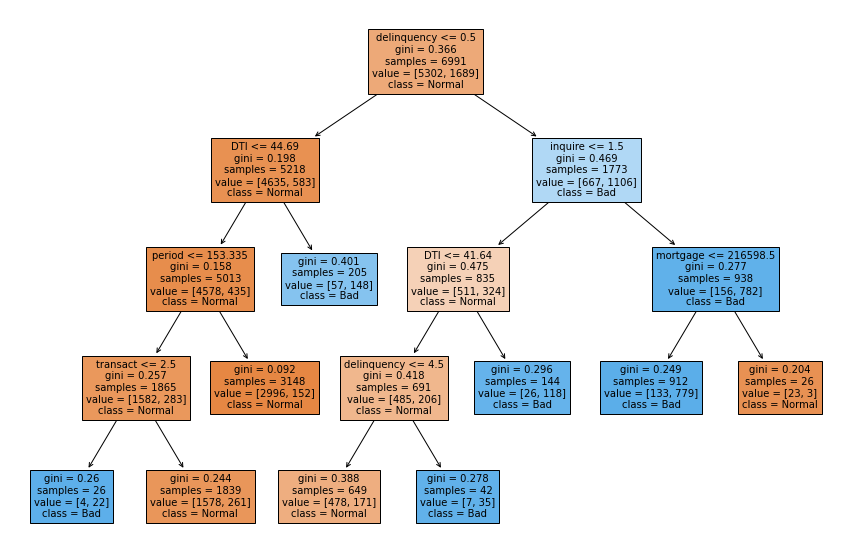

In [ ]:
c_tree = DecisionTreeClassifier(ccp_alpha=0.0033,random_state=0) 
c_tree.fit(X, y)
plt.figure(figsize=(15,10))
plot_tree(c_tree, feature_names=xname, class_names=yname, filled=True, fontsize=10) 
plt.show()

### 하이퍼파라미터 튜닝

In [ ]:
# 알파 뿐만 아니라, 여러 조건을 복합적으로 고려해 정확도를 출력 !
np.random.seed(0)
g_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),
              param_grid={'ccp_alpha': np.arange(0.000, 0.005, 0.0001),
                          'min_impurity_decrease': np.arange(0,0.003,0.0005),
                          'min_samples_split': np.arange(800,1200,200)},
                    cv=10, n_jobs=-1)
g_cv.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031,
       0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039,
       0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049]),
                         'min_impurity_decrease': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
                         'min_samples_split': array([ 800, 1000])})

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)
# score 가 올라갔다!

selected: {'ccp_alpha': 0.0, 'min_impurity_decrease': 0.001, 'min_samples_split': 1000}
score   : 0.7398759452278766


### Alpha=0.0, min_impurity_decrease=0.001,  min_samples_split=1000  트리

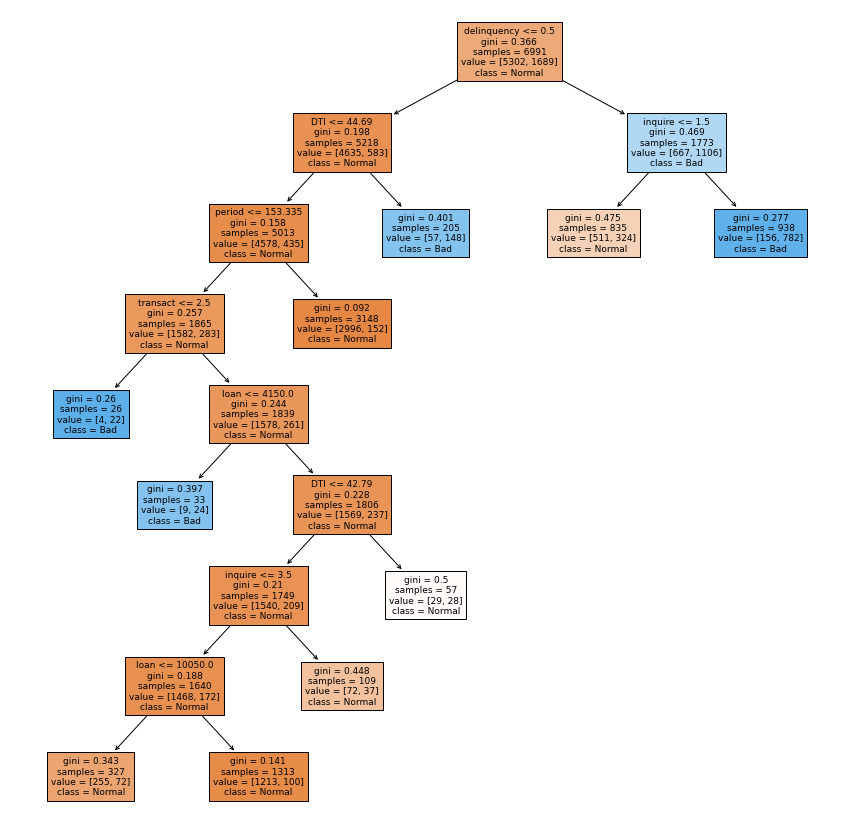

In [ ]:
c_tree = DecisionTreeClassifier(ccp_alpha=0.0,min_impurity_decrease=0.001,min_samples_split=1000,random_state=0) 
c_tree.fit(X, y)
plt.figure(figsize=(15,15))
plot_tree(c_tree, feature_names=xname, class_names=yname, filled=True, fontsize=9) 
plt.show()